In [47]:
import numpy as np
import matplotlib.pyplot as plt
import h5py
import datetime
import math

from obspy.io.segy.core import _read_segy
import scipy.fftpack as ft

from scipy import signal
from scipy import stats

import warnings
warnings.simplefilter('ignore')

In [48]:
# requires Jin's DASLowFreqProcessing modules
from DASLowFreqProcessing import spool,terra_io,lfproc
%matplotlib inline
# change to inline for not interactive plots

In [49]:
def find_nearest(arr: np.array, value: float) -> int:
    '''
    Finds the nearest element to the input value in the array
    '''
    idx = np.searchsorted(arr, value, side="left")
    if idx > 0 and (idx == len(arr) or math.fabs(value - arr[idx-1]) < math.fabs(value - arr[idx])):
        return idx
    else:
        return idx
    
def find_peak(arr: np.array, i: int, j: int, k: int) -> int:
    '''
    Finds the peak in the 2D array within given 1D segment
    Specifically used for finding the bad coupling channels in magnitude spectra
    '''
    seg = np.log10(arr[i,j:k]) # Slice the array into a line segment
    peak = int(np.where(seg == np.amax(seg))[0])
    print(j+peak)
    return j+peak

In [129]:
class jin_data:
    '''
    Handles the initial processing and plotting of DAS and sweep data
    Requires DASLowFreqProcessing modules
    '''
    
    def __init__(self):
        self.DASdata = np.empty(0)
        self.sweep = np.empty(0)
        self.dist = np.empty(0)
        
    def read_sweep(self, npoint: int, sweep: str, datapath: str) -> None:
        '''
        npoint: nth trigger point
        Read in the sweep data given the sweep filename and datapath
        Assumes the sweep data file is in segy format
        '''
        self.npoint = npoint
        
        sweepname = datapath + sweep
        self.st = _read_segy(sweepname)
        
        # read beginning and end time from the data as np.datetime64 objects
        self.bgtime = np.datetime64(str(self.st[0].stats.starttime)[0:-1])
        self.edtime = np.datetime64(str(self.st[0].stats.endtime)[0:-1])
        
    def read_data(self, datapath: str) -> None:
        '''
        Read in the DAS data with matching time with the sweep data
        Requires read_sweep() to have run beforehand
        '''
        sp = terra_io.create_spool(datapath)
        sp.get_time_segments()

        self.DASdata = sp.get_patch(self.bgtime,self.edtime)[0]
        self.DASdata = self.DASdata.tran.velocity_to_strain_rate()
        
        # resample the sweep data to match DAS data's sampling rate
        self.sweep = signal.resample(self.st[0].data/max(self.st[0].data), self.DASdata.data.shape[0])
        
        # store distance and time data
        self.dist = self.DASdata.coords['distance']
        self.time = self.DASdata.coords['time']

    def plot_sweep(self, drivelevel = False) -> None:
        '''
        Plot the sweep data for time vs amplitude unless user specifies it to plot for time vs drive level
        '''

        if drivelevel:
            plt.figure(figsize = (10,5))
            plt.plot(self.time, self.sweep)
            
            plt.ylabel("Amplitude")

            plt.show()
            
        else:
            fig = plt.figure(figsize=(10,5))
            ax = fig.add_subplot(1,1,1)
            ax.plot(self.st[0].times("matplotlib"), self.st[0].data)

            ax.xaxis_date()
            fig.autofmt_xdate()
            
            plt.ylabel("Drive Level (kN)")

        plt.title(f"Sweep at Trigger Point {self.npoint}")
        plt.xlabel("Time (UTC)")
        plt.show()
        
    def plot(self, data, scale = 0.01) -> None:    # here can fix the correlated data
        '''
        Plots the DAS data using waterfall scaled at scale
        '''
        
        plt.figure(figsize = (7,7))
        plt.imshow(data, cmap = 'seismic', interpolation = 'nearest', aspect = 'auto', extent = (1.54, 1023.3091457785043, 0.06, 0))
        plt.colorbar()
        
        #self.DASdata.viz.waterfall(scale = scale)
               
    def correlate(self) -> None:
        '''
        Cross-correlate stores DAS and sweep data
        '''
        self.corr_data = np.empty(self.DASdata.data.shape)
        for i in range(self.DASdata.data[0].shape[0]):
            self.corr_data[:,i] = signal.correlate(self.DASdata.data[:,i], self.sweep, mode='same')
        
    def plot_powerspec(self, pspec: np.array, m: int) -> None:
        '''
        Plot the power spectrum of the array taken as an input
        specify the max frequency extent using m
        '''
        
        #create the min and max values
        vmin = np.percentile(np.log(pspec),5)
        vmax = np.percentile(np.log(pspec),95)

        plt.figure(figsize=(7,7))
        plt.title('Magnitude Spectrum of Trigger #40')
        plt.imshow(np.log10(pspec), aspect='auto',cmap='summer', extent=(1,1023.3091457785043,m,0))
        plt.clim(vmin= vmin,vmax=vmax)
        plt.colorbar(label = "Strain Rate($\log_{10}(1/s^2)$)")
        plt.xlabel("Distance (m)")
        plt.ylabel("Frequency (Hz)")
        
        plt.show()

In [130]:
class corrcoef():
    '''
    Calculates the correlation coefficients
    Does not require DASLowFreqProcessing modules
    '''
    
    def __init__(self, data: np.array, buf = 4):
        self.buf = buf
        self.data = data
        self.init_matrix = np.empty((self.data.shape[1]-self.buf, self.buf))
        self.corr_matrix = np.empty(0)
        self.median = 0

    def pearson(self):
        '''
        Calculates the correlation coefficients using Pearson
        '''
        
        # compare buf number of neiboring channels
        for i in range(self.data.shape[1]-self.buf):
            for j in range(1,self.buf):
                self.init_matrix[i,j] = stats.pearsonr(self.data[:,i], self.data[:,i+j])[0]

        self.corr_matrix = np.zeros(self.init_matrix.shape[0])
        
        # take the median of the coefficients calculated above and assign the median for each channel
        for i in range(self.init_matrix.shape[0]):
            self.corr_matrix[i] = np.median(self.init_matrix[i,:])

        # store the median of all coefficient values
        self.median = np.median(self.corr_matrix)

    def spearman(self):
        '''
        Calculates the correlation coefficients using Spearman
        '''
        
        # compare buf number of neiboring channels
        for i in range(self.data.shape[1]-self.buf):
            for j in range(1,self.buf):
                self.init_matrix[i,j] = stats.spearmanr(self.data[:,i], self.data[:,i+j], axis = None, nan_policy = 'omit')[0]

        self.corr_matrix = np.zeros(self.init_matrix.shape[0])
        
        # take the median of the coefficients calculated above and assign the median for each channel
        for i in range(self.init_matrix.shape[0]):
            self.corr_matrix[i] = np.median(self.init_matrix[i,:])

        # store the median of all coefficient values
        self.median = np.median(self.corr_matrix)

    def stats(self):
        '''
        Print the mean and median of all stores correlation coefficient values
        '''
        print(f"Mean: {np.mean(self.corr_matrix)}, median = {np.median(self.corr_matrix)}")

    def find_bad(self, thresh: int) -> np.array:
        '''
        Find the indices of correlation coefficients where the value is less than the threshhold value as a numpy array
        '''
        self.bad = np.array(np.where(self.corr_matrix < thresh))
        return self.bad

    def plot_corr(self):
        '''
        Plot all correlation coefficients
        '''
        plt.title(f"Correlation Coefficient at buffer {self.buf}")
        plt.plot(self.corr_matrix)

        plt.xlabel("Channel Number")
        plt.ylabel("Correlation Coefficient")

        plt.show()

    def plot_hist(self):
        '''
        Plot the histogram of all correlation coefficients
        '''
        plt.title(f"Correlation Coefficient at buffer {self.buf}")
        plt.hist(self.corr_matrix)

        plt.xlabel("Correlation Coefficient")
        plt.ylabel("Occurences")

        plt.show()

In [131]:
DAS = jin_data()
DAS.read_sweep(70, '5416_220524_192704_352000.sgy', '/Users/veneziafollingstad/Desktop/The Business/FieldSessionProcessing/2022_05_24_vibroseis_data/')
DAS.read_data('/Users/veneziafollingstad/Desktop/The Business/FieldSessionProcessing/UTC-YMD20220524-HMS183838.173')
DAS.correlate()

/Users/veneziafollingstad/Desktop/The Business/FieldSessionProcessing/UTC-YMD20220524-HMS183838.173/Road22side_velocity_UTC-YMD20220524-HMS185643.040_seq_00000000011.hdf5

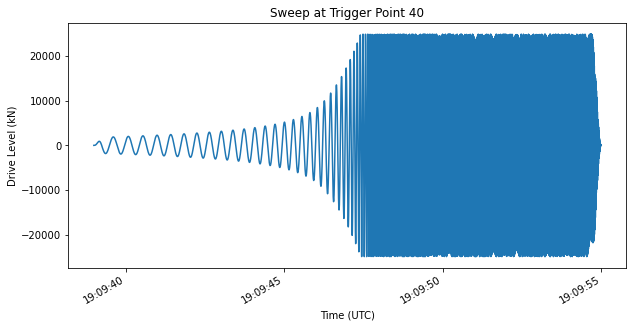

In [109]:
DAS.plot_sweep()

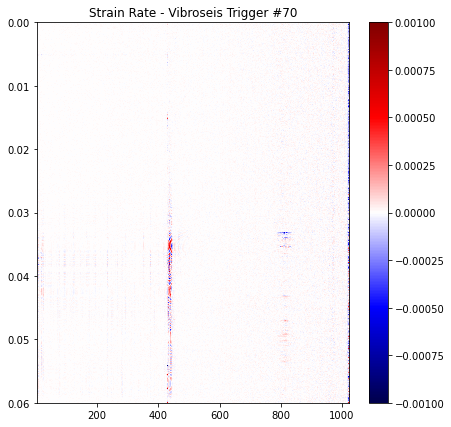

In [110]:
DAS.plot(DAS.DASdata.data)
ntrig = 70
plt.title(f"Strain Rate - Vibroseis Trigger #{ntrig}")
plt.clim([-0.001,0.001])

plt.show()

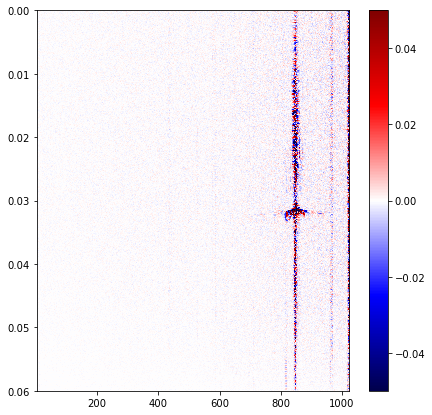

In [115]:
DAS.plot(DAS.corr_data)
plt.clim([-0.05,0.05])

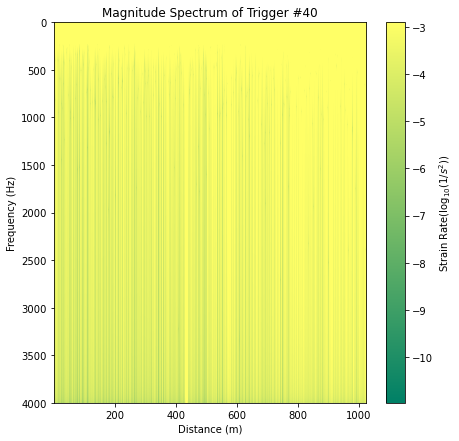

In [132]:
DAS.plot_powerspec(np.abs(ft.rfft(DAS.corr_data, axis=0)), 4000)

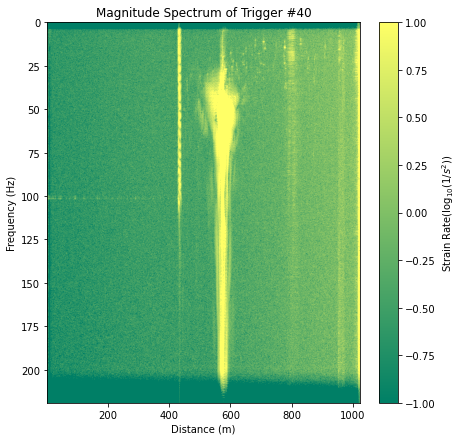

In [127]:
# i = 525, 526, 818, 1176
DAS.plot_powerspec(np.abs(ft.rfft(DAS.corr_data,axis=0))[0:3500,:], 219)

In [ ]:
DAS = jin_data()
DAS.read_sweep('5416_220524_192640_288000.sgy')
DAS.read_data()
DAS.correlate()

In [ ]:
# i = 529, 534, 605, 967, 1168
# generator noise near spool 
DAS.plot_powerspec(np.abs(ft.rfft(DAS.corr_data, axis=0))[0:3500,:])

In [ ]:
# 2022-05-24T20:37:35
DAS = jin_data()
DAS.read_sweep('5416_220524_203740_672000.sgy')
DAS.read_data()
DAS.correlate()

In [ ]:
test = np.abs(ft.rfft(DAS.corr_data,axis=0))

In [ ]:
find_peak(test, 200, 900, 1000)

In [ ]:
# i = 525, 564, 709, 866, 981 
DAS.plot_powerspec(np.abs(ft.rfft(DAS.corr_data, axis=0))[0:3500,:])

In [ ]:
DAS = jin_data()
DAS.read_sweep('5416_220524_203039_352000.sgy')
DAS.read_data()
DAS.correlate()

In [ ]:
test = np.abs(ft.rfft(DAS.corr_data,axis=0))

In [ ]:
find_peak(test, 2000, 1160, 1200)

In [ ]:
# i = 1181
DAS.plot_powerspec(np.abs(ft.rfft(DAS.corr_data, axis=0))[0:3500,:])

In [ ]:
#looking at a flick test 

# 2022-05-24T20:37:35
DAS = jin_data()
DAS.read_sweep('5416_220524_203740_672000.sgy')
DAS.read_data()
DAS.correlate()


In [ ]:
#show not zoomed
#identify end of spool 
#compare power specs to see if there are consistent trends in the channels
#center line might align with location of vibroseis?
#rule out channels too close to source? 
#1/r correction for power spectra before log --> accounting for surface waves
#can normalize power spectra, go through each channel divide every entry of power spec find l**2 norm 

In [ ]:
plt.figure(figsize=(5,5))
plt.plot(np.abs(ft.rfft(DAS.sweep)))
plt.show()

In [ ]:
plt.close('all')